# Speech Prominence Detection
Speech Prominence Detection is the process of identifying the most important or prominent parts of speech in an audio signal. Prominence refers to the degree of emphasis or attention that a particular word or phrase receives in spoken language, which is often conveyed through variations in pitch, loudness, and timing. Speech Prominence Detection is an essential task in speech processing and natural language understanding, with a wide range of applications including speech recognition, sentiment analysis, and language translation. The goal of this project is to develop a machine learning model that can accurately identify the prominent parts of speech in a given audio signal. This project will involve feature extraction, model training, and evaluation, with the aim of achieving high accuracy and generalizability on a diverse range of speech datasets. The results of this project could have significant implications for improving speech recognition and understanding systems in real-world applications.

In [2]:
# imports
import numpy as np
import pandas as pd
import re
import os
import collections
import scipy
from scipy.signal import medfilt
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

In [3]:
from myfunctions import spectral_selection,  temporal_corr, get_labels_seq2seq
from myfunctions import spectral_corr, smooth, vocoder_func

## Datasets

In [4]:
data_dir = "../data/"
ger_test_dir = os.path.join(data_dir, "GER/test/")
ger_train_dir = os.path.join(data_dir, "GER/train/")
ita_test_dir = os.path.join(data_dir, "ITA/test/")
ita_train_dir = os.path.join(data_dir, "ITA/train/")

phn_dir = os.path.join(data_dir, "fisher-2000_FA_GT_ESTphnTrans_estStress/lab/txt/phn/")
dict_name = "nativeEnglishDict_gt100_manoj.syl"
stressLabelspath = data_dir + "FA_htkCorrectedLabWithFullAudio" + "/lab/mat/sylStress/"

In [5]:
# chech if the directories exist
if not os.path.exists(data_dir):
    print("Data directory does not exist")
if not os.path.exists(ger_train_dir):
    print("German Train directory does not exist")
if not os.path.exists(ita_train_dir):
    print("Italian Train directory does not exist")
if not os.path.exists(phn_dir):
    print("Phoneme directory does not exist")

In [6]:
ger_test_files = os.listdir(ger_test_dir)
ger_train_files = os.listdir(ger_train_dir)
ita_test_files = os.listdir(ita_test_dir)
ita_train_files = os.listdir(ita_train_dir)

## Variables

In [7]:
# Compute features
twin = 5
t_sigma = 1.4
swin = 7
s_sigma = 1.5
mwin = 13
max_threshold = 25

vwlSB_num = 4
vowelSB = [1, 2, 4, 5, 6, 7, 8, 13, 14, 15, 16, 17]
sylSB_num = 5
sylSB = [1, 2, 3, 4, 5, 6, 13, 14, 15, 16, 17, 18]

startWordFrame_all = []
spurtStartFrame_all = []
spurtEndFrame_all = []
vowelStartFrame_all = []
vowelEndFrame_all = []
eng_full_all = []
spurtStress_all = []

In [8]:
def get_data_array(phn_file):
    data_array = []
    try:
        fid = open(phn_file, 'r')
        data_array = np.loadtxt(fid, dtype={'names': ('a', 'b', 'c'), 'formats': ('f4', 'f4', 'S16')})
        fid.close
    except:
        print('File does not exist')
        return

    ghastly = []
    for i in range(len(data_array)):
        tuple_list = list(data_array[i])
        tuple_list[2] = tuple_list[2].decode()
        ghastly.append((tuple_list[0], tuple_list[1], tuple_list[2]))
    return np.array(ghastly)

In [9]:
def get_phone_data(data_array):
    phnTimes1 = [row[0] for row in data_array]
    phnTimes1 = np.array([phnTimes1]).T

    phnTimes2 = [row[1] for row in data_array]
    phnTimes2 = np.array([phnTimes2]).T

    phnTimes = np.hstack((phnTimes1, phnTimes2))
    phones = [row[2] for row in data_array]
    phones = np.array([phones])

    # Made them lowercase since the syl dictionary is in lowercase
    for i in range(0, len(phones[0])):
        phones[0][i] = phones[0][i].lower()
        
    origPhones = phones
    index = np.argwhere(origPhones[0] == 'sil')
    phones = phones[phones != 'sil']
    phones = np.array([phones])
    phones = phones.reshape(1, -1)

    phnTimes2 = np.delete(phnTimes2, index, axis=0)
    phnTimes = np.delete(phnTimes, index, axis=0)
    
    return phones, phnTimes

In [10]:
# Getting vowel data
def get_vowel_data(data_array):
    # VOWEL LIST
    vowelList = ['aa', 'ae', 'ah', 'ao', 'aw', 'ay', 'eh', 'er', 'ey', 'ih', 'iy', 'ow', 'oy', 'uh', 'uw']
    vowel_start_time = []
    vowel_end_time = []
    vowel = []

    for i in range(0, len(data_array)):
        if data_array[i][2].lower() in vowelList:
            vowel_start_time.append(data_array[i][0])
            vowel_end_time.append(data_array[i][1])
            vowel.append(data_array[i][2].lower())
            
    vowel_start_time = np.array([vowel_start_time])
    vowel_end_time = np.array([vowel_end_time])
    vowel = np.array([vowel])
    return vowel, vowel_start_time, vowel_end_time

In [11]:
def get_words(file_name):
    # Define the path to the transcript file
    trans_path = data_dir + "ISLEtrans.txt"

    # Read the contents of the transcript file
    with open(trans_path, 'r') as trans_file:
        trans_contents = trans_file.read()

    # Extract the lines containing the specified filename from the transcript
    lines = [line for line in trans_contents.split('\n') if file_name in line]

    # Extract the words from the lines and clean them up
    words = []
    for line in lines:
        _, word_list = line.split(' ', 1)
        words.extend(re.findall(r'\b\w+\b', word_list))
    words = [word.lower() for word in words]
    return words

In [12]:
def get_word_syls(words):
    d = collections.defaultdict(list)
    with open(data_dir + dict_name, 'r') as f:
        for line in f:
            key = line.split()[0]
            val = line.split('=')[1].strip()
            d[key].append(val)

    word_syls = []
    for i in range(len(words)):
        curr_word_syls = []
        if words[i] in d:
            curr_word_syls = d[words[i]]
        word_syls.append(curr_word_syls)
    return word_syls

In [13]:
def get_path_indices(words, word_syls, phones):
    newSuccessInds_all = []
    newSuccessInds_all2 = []

    prevSuccessInds_all = []
    prevSuccessInds_all.append(0)

    # I said got not goat
    for iterWord in range(0, len(words)):
        currWordSyls = word_syls[iterWord]
        countSuccess = 1

        for iterPrev in range(0, len(prevSuccessInds_all)):
            prevWordSyls = ""
            if prevSuccessInds_all[iterPrev] == 0:
                currPrevSylInds = []
            else:
                currPrevSylInds = prevSuccessInds_all[iterPrev]
                for iterPrevSyls in range(0, len(currPrevSylInds)):
                    temp = word_syls[iterPrevSyls]
                    prevWordSyls = prevWordSyls + \
                        temp[currPrevSylInds[iterPrevSyls]]+" "

            # iterating through the syllables of the current word
            for iterCurr in range(0, len(currWordSyls)):
                currTestWordSyls = prevWordSyls + currWordSyls[iterCurr]
                temp2 = currTestWordSyls.replace(' . ', ' ')
                
                
                inds = [m.start() for m in re.finditer(' ', temp2)]
                if len(inds) == 0:
                    inds = [len(temp2)]

                count = 1
                temp = []

                for iterTemp in range(len(inds)):
                    if iterTemp == 0:
                        temp1 = temp2[0:inds[iterTemp]]
                        # print(temp2 + "\t\t| " + temp1)
                    else:
                        temp1 = temp2[inds[iterTemp-1]+1:inds[iterTemp]]
                    if not ((np.unique(temp1) == ' ').any() or (len(temp1) == 0)):
                        temp.append(temp1)
                        count += 1
                        
                if iterTemp == len(inds) - 1 and len(inds) < len(currTestWordSyls):
                    temp1 = temp2[inds[iterTemp]+1:len(temp2)]
                    if not ((len(temp1) == 0) or (np.unique(temp1) == ' ').any()):
                        temp.append(temp1)
                        count = count+1

                if iterWord + 1 == len(words):
                    currPhones = phones[0, 0:len(phones[0])]
                else:
                    currPhones = phones[0][0:len(temp)]

                    
                flag = 1
                for iterFlag in range(0, len(currPhones), 1):
                    if len(currPhones) != len(temp):
                        flag = 0
                    else:
                        if currPhones[iterFlag] != temp[iterFlag]:
                            flag = 0
                if flag == 1:
                    if not currPrevSylInds == []:
                        for i in range(0, len(currPrevSylInds)):
                            #                            print('line 122::::::yes')
                            newSuccessInds_all.append(currPrevSylInds[i])
                    newSuccessInds_all.append(iterCurr)
                    newSuccessInds_all2.append(newSuccessInds_all)
                    newSuccessInds_all = []
                    countSuccess = countSuccess+1
                    
        prevSuccessInds_all = newSuccessInds_all2
        newSuccessInds_all2 = []
    if len(prevSuccessInds_all) == 0:
        return None, None
    return prevSuccessInds_all[0], currTestWordSyls

In [14]:
def get_syls_count(path_indices, currTestWordSyls, words, word_syls):
    sylCount = 1
    phnCount = 1
    spurtSyl = []  # spurtSylTimes= np.zeros((len(phnTimes),2))

    syls_word = np.zeros((1, len(path_indices)))
    spurtWordTimes = np.zeros((len(path_indices), 2))

    for iterPath in range(0, len(path_indices)):
        # current word and syllables
        currWord = words[iterPath]
        currWordSyls = word_syls[iterPath]

        currSyl = currWordSyls[path_indices[iterPath]]
        currSyl = currSyl.replace(' . ', '.')
        # print(currSyl)
        inds = [m.start() for m in re.finditer('\.', currSyl)]

        if len(inds) == 0:
            inds = [len(currSyl)]

        count = 0
        for iterTemp in range(0, len(inds)):
            if iterTemp == 0:
                temp1 = currSyl[0:inds[iterTemp]]
            else:
                temp1 = currSyl[inds[iterTemp-1]+1:inds[iterTemp]]
            if not (temp1 == ' ' or len(temp1) == 0):
                spurtSyl.append(temp1)
                sylCount = sylCount + 1
                count = count + 1
                
        if iterTemp is len(inds)-1 and len(inds) < len(currTestWordSyls):
            temp1 = currSyl[inds[iterTemp]+1:len(currSyl)]
            if not (temp1 == ' ' or len(temp1) == 0):
                spurtSyl.append(temp1)
                sylCount = sylCount + 1
                count = count + 1
        syls_word[0][iterPath] = count

    return syls_word, spurtSyl, spurtWordTimes

In [15]:
def get_spurts(spurtSyl, currTestWordSyls, phnTimes):
    phnCount = 1
    spurtSylTimes = np.zeros((len(spurtSyl), 2))

    for iterSyl in range(0, len(spurtSyl)):
        temp2 = spurtSyl[iterSyl]
        inds = [m.start() for m in re.finditer(' ', temp2)]
        if len(inds) == 0:
            inds = [len(temp2)]
        count = 1
        temp = []
        for iterTemp in range(0, len(inds)):
            if iterTemp == 0:
                temp1 = temp2[0:inds[iterTemp]]
            else:
                temp1 = temp2[inds[iterTemp-1]+1:inds[iterTemp]]
            if not (temp1 == ' ' or len(temp1) == 0):
                temp.append(temp1)
                count = count+1
        if iterTemp == len(inds)-1 and len(inds) < len(currTestWordSyls):
            temp1 = temp2[inds[iterTemp]+1:len(temp2)]
            if not (temp1 == ' ' or len(temp1) == 0):
                temp.append(temp1)
                count = count+1

        nPhns_syl = len(temp)
        spurtSylTimes[iterSyl, 0] = phnTimes[phnCount-1, 0]
        phnCount = phnCount + nPhns_syl
        spurtSylTimes[iterSyl, 1] = phnTimes[phnCount-1-1, 1]
    return spurtSylTimes

In [16]:
def get_spurt_word_times(path_indices, syls_word, spurtSylTimes):
    spurtWordTimes = np.zeros((len(path_indices), 2))
    sylIdx = 1

    for iterWordTimes in range(0, len(syls_word[0])):
        spurtWordTimes[iterWordTimes][0] = spurtSylTimes[sylIdx-1][0]
        sylIdx = sylIdx + syls_word[0][iterWordTimes].astype(int)
        spurtWordTimes[iterWordTimes][1] = spurtSylTimes[sylIdx-1-1][1]
    length_spurtWordTimes = iterWordTimes + 1
    return spurtWordTimes

In [17]:
def process_word_boundaries(spurtWordTimes, words, spurtSylTimes):
    # Processing word boundary file
    # FILE READ DELETED HERE
    a = spurtWordTimes
    b = words
    if (len(a) is not len(b)):
        print("error")
    wordData = np.hstack((a, np.array([b], dtype='S32').T))

    # Extract first coloumn of wordData
    startWordTime = [row[0] for row in wordData]
    endWordTime = [row[1] for row in wordData]

    startWordFrame = np.round((np.subtract(np.array(startWordTime, dtype='float'), spurtSylTimes[0][0].astype(float))*100))
    endWordFrame = np.round((np.subtract(np.array(endWordTime, dtype='float'), spurtSylTimes[0][0].astype(float))*100) + 1)
    startWordFrame = np.append(startWordFrame, endWordFrame[-1])

    return startWordFrame, endWordFrame

In [18]:
def get_sylTCSSBC(sylSB, eng_full, sylSB_num, twin, t_sigma, swin, s_sigma, spurtStartTime, vowelStartTime, startWordFrame):
    # TCSSBC computation
    if len(sylSB) > sylSB_num:
        eng = spectral_selection(
            eng_full[np.subtract(sylSB, 1), :], sylSB_num)
    else:
        eng = eng_full[sylSB, :]

    t_cor = temporal_corr(eng, twin, t_sigma)
    s_cor = spectral_corr(t_cor)
    sylTCSSBC = smooth(s_cor, swin, s_sigma)
    sylTCSSBC = np.array([sylTCSSBC])

    start_idx = np.round(spurtStartTime[0]*100).astype(int)
    sylTCSSBC = np.array([sylTCSSBC[0][start_idx:-1]])

    sylTCSSBC = np.divide(sylTCSSBC, max(sylTCSSBC[0]))

    if len(vowelSB) > vwlSB_num:
        eng = spectral_selection(
            eng_full[np.subtract(vowelSB, 1), :], vwlSB_num)
    else:
        eng = eng_full[vowelSB, :]
    t_cor = temporal_corr(eng, twin, t_sigma)
    s_cor = spectral_corr(t_cor)
    vwlTCSSBC = smooth(s_cor, swin, s_sigma)

    vwlTCSSBC = np.array([vwlTCSSBC])

    # Modify TCSSBC contour by clipping from the vowel start
    start_idx = np.round(vowelStartTime[0][0]*100).astype(int)
    vwlTCSSBC = np.array([vwlTCSSBC[0][start_idx:-1]])

    vwlTCSSBC = np.divide(vwlTCSSBC, max(vwlTCSSBC[0]))

    # Compute silence statistics
    # Preprocessing of the data
    word_duration = np.zeros((1, len(startWordFrame) - 1))
    word_Sylsum = np.zeros((1, len(startWordFrame) - 1))
    word_Vwlsum = np.zeros((1, len(startWordFrame) - 1))

    for j in range(0, len(startWordFrame) - 1):
        temp_start = startWordFrame[j].astype(int)
        temp_end = startWordFrame[j + 1].astype(int) - 1
        # jhansi
        if (temp_end >= sylTCSSBC.shape[1]):
            temp_end1 = sylTCSSBC.shape[1]-1
            sylTCSSBC[0, np.arange(temp_start, temp_end1)] = medfilt(
                sylTCSSBC[0, np.arange(temp_start, temp_end1)], 3)
            sylTCSSBC[0, temp_start] = sylTCSSBC[0, temp_start+1]
            sylTCSSBC[0, temp_end1] = sylTCSSBC[0, temp_end1 - 1]
            tempArr = sylTCSSBC[0, np.arange(temp_start, temp_end1)]
            word_Sylsum[0, j] = tempArr.sum(axis=0)
        else:
            sylTCSSBC[0, np.arange(temp_start, temp_end)] = medfilt(
                sylTCSSBC[0, np.arange(temp_start, temp_end)], 3)
            sylTCSSBC[0, temp_start] = sylTCSSBC[0, temp_start+1]
            sylTCSSBC[0, temp_end] = sylTCSSBC[0, temp_end - 1]
            tempArr = sylTCSSBC[0, np.arange(temp_start, temp_end)]
            word_Sylsum[0, j] = tempArr.sum(axis=0)
        if (temp_end >= vwlTCSSBC.shape[1]):
            temp_end = vwlTCSSBC.shape[1]-1

        #    temp_end = np.min([temp_end,len(vwlTCSSBC)])
        vwlTCSSBC[0, np.arange(temp_start, temp_end)] = medfilt(
            vwlTCSSBC[0, np.arange(temp_start, temp_end)], 3)
        vwlTCSSBC[0, temp_start] = vwlTCSSBC[0, temp_start+1]
        vwlTCSSBC[0, temp_end] = vwlTCSSBC[0, temp_end - 1]

        word_duration[0, j] = temp_end - temp_start + 1

        tempArr = vwlTCSSBC[0, np.arange(temp_start, temp_end)]
        word_Vwlsum[0, j] = tempArr.sum(axis=0)

    sylTCSSBC[np.isnan(sylTCSSBC)] = 0   # Feature vector 1
    vwlTCSSBC[np.isnan(vwlTCSSBC)] = 0   # Feature vector 2
    return sylTCSSBC[0]

In [19]:
def chunk_feature_contour(sylTCSSBC, spurtStartFrame, spurtEndFrame):
    # Chunking the feature contour
    sylTCSSBC_chunk = []
    for i in range(0, len(spurtStartFrame)):
        sylTCSSBC_chunk.append(sylTCSSBC[int(spurtStartFrame[i]):int(spurtEndFrame[i])])
    return np.array(sylTCSSBC_chunk)

## Feature Contour Generator
This function extracts the relevant information from raw speech data and composes feature contours for the dataset.

In [20]:
def feature_contour(wav_file, test_data):
    file_name = wav_file[:-4]
    phn_file = phn_dir + file_name + ".txt"
    mat_file = stressLabelspath + file_name + ".mat"

    

    if not os.path.exists(phn_file):
        print("phn file doesn't exist")
        return None, None, False, None
    
    if not os.path.exists(mat_file):
        print("mat file doesn't exist")
        return None, None, False, None

    data_array = get_data_array(phn_file)
    phones, phn_times = get_phone_data(data_array)
    vowel, vowel_start_time, vowel_end_time = get_vowel_data(data_array)
    words = get_words(file_name)
    word_syls = get_word_syls(words)
    path_indices, currTestWordSyls = get_path_indices(words, word_syls, phones)

    
    

    if path_indices == None:
        return None, None, False, None
    syls_word, spurtSyl, spurtWordTimes = get_syls_count(path_indices, currTestWordSyls, words, word_syls)
    spurtSylTimes = get_spurts(spurtSyl, currTestWordSyls, phn_times)
    syls_word = syls_word.astype('i')

    spurtWordTimes = get_spurt_word_times(path_indices, syls_word, spurtSylTimes)

    

    

    # Execute the vocoder [MODIFICATION]: Get the audio file back so that it can be stored in a text file for C code.
    file_dir = ger_test_dir if test_data else ger_train_dir
    eng_full, xx = vocoder_func(file_dir + wav_file)
    eng_full = eng_full.conj().transpose()


    startWordFrame, endWordFrame = process_word_boundaries(spurtWordTimes, words, spurtSylTimes)

    # Processing of stress and syllable boundary file
    spurtSylTime = spurtSylTimes
    spurtStartTime = spurtSylTime[:, 0]
    spurtEndTime = spurtSylTime[:, 1]
    spurtStartFrame = np.round((spurtStartTime - spurtStartTime[0]) * 100)
    spurtEndFrame = np.round((spurtEndTime - spurtStartTime[0]) * 100)

    # Processing of Vowel boundary file
    vowel_start_time = vowel_start_time.astype(float)
    vowel_end_time = vowel_end_time.astype(float)

    vowelStartFrame = np.round(vowel_start_time*100 - spurtStartTime[0]*100)
    vowelEndFrame = np.round(vowel_end_time*100 - spurtStartTime[0]*100)


    # print("words = ", words)
    # print("spurt start time = ", spurtStartTime, len(spurtStartTime))
    # print("vowel start time = ", vowel_start_time, len(vowel_start_time[0]))
    # print("start word frame = ", startWordFrame, len(startWordFrame))
    # print("spurt start frame = ", spurtStartFrame, len(spurtStartFrame))
    # print("spurt end frame = ", spurtEndFrame, len(spurtEndFrame))
    print("words = ", words)
    print("syls word = ", syls_word, len(syls_word))

    polym = []
    poly = []
    origsyls_word = syls_word

    # Filter by number of syllables
    FILTER = 2
    for n in syls_word[0]:
        if n != FILTER:
            polym.extend([False] * n)
            poly.append(False)
        else:
            polym.extend([True] * n)
            poly.append(True)
    num_poly = np.sum(polym)
    if num_poly == 0:
        return None, None, None, None

    # eliminate the monosyllabic words using the poly list
    print("Poly = ", poly)
    print("polym = ", polym)
    
    syls_word = syls_word[0][poly]
    spurtStartTime = spurtStartTime[polym]
    vowel_start_time = np.array([vowel_start_time[0][polym]])
    startWordFrame = startWordFrame[poly.append(True)]
    spurtStartFrame = spurtStartFrame[polym]
    spurtEndFrame = spurtEndFrame[polym]


    # print()
    print("syls word = ", syls_word, len(syls_word))

    # print("spurt start time = ", spurtStartTime, len(spurtStartTime))
    # print("vowel start time = ", vowel_start_time, len(vowel_start_time))
    # print("start word frame = ", startWordFrame, len(startWordFrame))
    # print("spurt start frame = ", spurtStartFrame, len(spurtStartFrame))
    # print("spurt end frame = ", spurtEndFrame, len(spurtEndFrame))




    sylTCSSBC = get_sylTCSSBC(sylSB, eng_full, sylSB_num, twin, t_sigma, swin, s_sigma, spurtStartTime, vowel_start_time, startWordFrame)
    sylTCSSBC_chunk = chunk_feature_contour(sylTCSSBC, spurtStartFrame, spurtEndFrame)
    print(sylTCSSBC_chunk.shape)
    print("Len of sylTCSSBC_chunk = ", len(sylTCSSBC_chunk))
    print("Syl TCSSBC = ", sylTCSSBC_chunk)




    # extract label
    mat = scipy.io.loadmat(stressLabelspath + file_name + '.mat')
    lab = mat['spurtStress']
    lab_list = lab.tolist()
    labels = get_labels_seq2seq(lab_list)  # Labels
    if len(labels) != len(polym):
        return None, None, False, None
    
    labels = [labels[i] for i in range(len(labels)) if polym[i]]

    if len(sylTCSSBC_chunk) != len(labels):
        return None, None, False, None

    onlypoly_words = [words[i] for i in range(len(words)) if polym[i]]
    return sylTCSSBC_chunk, labels, onlypoly_words, syls_word

## Test Dataset Generation Code

In [21]:
ger_train_files_subset = ger_train_files[56:58]
all_contours = []
all_labels = []
all_words = []
all_syls_word = []

for i, file in enumerate(ger_train_files_subset):
    print(i)
    contours, labels, words, syls_word = feature_contour(file, False)
    print(words)
    print()
    print()
    
    if contours == None: continue

    all_contours.extend(contours)
    all_labels.extend(labels)
    all_words.extend(words)
    all_syls_word.extend(syls_word)

0
words =  ['an', 'airport', 'terminal']
syls word =  [[1 2 3]] 1
Poly =  [False, True, False]
polym =  [False, True, True, False, False, False]
syls word =  [2] 1


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

## Generate the Dataset
Use `ger_train_files` for `train` and `ger_test_files` for `test` respectively. <br />
This process may take anywhere betweeen 1 and 2 hours.

In [21]:
# train data
all_chunks = []
all_labels = []
for i, file in enumerate(ger_test_files):
    chunks, labels, success, _ = feature_contour(file, True)

    if success: 
        all_chunks.extend(chunks)
        all_labels.extend(labels)   

    clear_output(wait=True)
    if success:
        print("Chunk length = ", len(chunks))

    print("Processed: {}/{}".format(i+1, len(ger_test_files)), end="\r")
    print("Progress: {:.2f}%".format((i+1)/len(ger_test_files)*100), end="\r")

In [22]:
# save train data as pickle
df = pd.DataFrame({'contour': all_chunks, 'labels': all_labels})
df.to_pickle('../saved/ger_test_syls3.pkl')

In [21]:
ger_train_files_subset = ger_train_files[56:58]
all_contours = []
all_labels = []
all_words = []
all_syls_word = []

for i, file in enumerate(ger_train_files_subset):
    print(i)
    contours, labels, words, syls_word = feature_contour(file, False)
    print()
    print()
    
    # if not valid: continue

    all_contours.extend(contours)
    all_labels.extend(labels)
    all_words.extend(words)
    all_syls_word.extend(syls_word)

0
words =  ['an', 'airport', 'terminal']
syls word =  [[1 2 3]] 1
syls word =  [2 3] 2
(5,)
Len of sylTCSSBC_chunk =  5
Syl TCSSBC =  [array([0.98497767, 0.99461823, 1.        , 0.98990266, 0.95111697,
        0.87190801, 0.74674895, 0.58338007, 0.40559315, 0.24521739,
        0.12708604, 0.05755976, 0.0257983 , 0.01506617, 0.01330798,
        0.01653358, 0.02675887, 0.04678707, 0.0772311 , 0.11758193])
 array([0.17291263, 0.25554124, 0.37504223, 0.52223942, 0.66585791,
        0.76752219, 0.80341387, 0.77043479, 0.67717787, 0.5383631 ,
        0.37855638, 0.22968349, 0.11843518, 0.05330051, 0.0250247 ,
        0.02001105, 0.03154989, 0.05966381, 0.10256843, 0.14975695,
        0.1856775 , 0.19936193, 0.19158553, 0.17403582, 0.16485429,
        0.18549753, 0.2526919 ])
 array([0.36456421, 0.49453219, 0.60337479, 0.66295721, 0.67221314,
        0.64951052, 0.61342481, 0.57172596, 0.52352574, 0.46581942,
        0.39878017, 0.32758565, 0.26143885, 0.20940347, 0.17617078,
        0.161223

In [21]:
# print(all_contours)
print(all_labels)
print(all_words)
print(all_syls_word)

[1, 0, 1, 0, 0, 1, 0, 0]
['airport', 'terminal', 'gallery']
[2, 3, 3]


In [22]:
contours_combined = []
contlens = []
all_contours_copy = all_contours.copy()
for num_syls in all_syls_word:
    current_contour = []
    current_contlen = []
    for i in range(num_syls):
        z = all_contours.pop(0)
        current_contour.extend(z)
        current_contlen.append(len(z))
    contlens.append(current_contlen)
    contours_combined.append(current_contour)

In [23]:
for cont in all_contours_copy:
    print(len(cont))

20
27
23
10
30
10
20
19


In [24]:
contlens

contlens_cumsum = []
for contlen in contlens:
    contlens_cumsum.append(np.cumsum(contlen))

In [25]:
contours_combined = np.array(contours_combined)
for cont in contours_combined:
    print(len(cont))

47
63
49


In [26]:
contlens_cumsum
all_labels

[1, 0, 1, 0, 0, 1, 0, 0]

# Syllable Boundaries in Words
This code can be used to create a microservice that detects syllable boundaries in speech data. <br />
In the context of Speech Prominence Detection, this can be used to understand how the syllable shapes the feature contours.

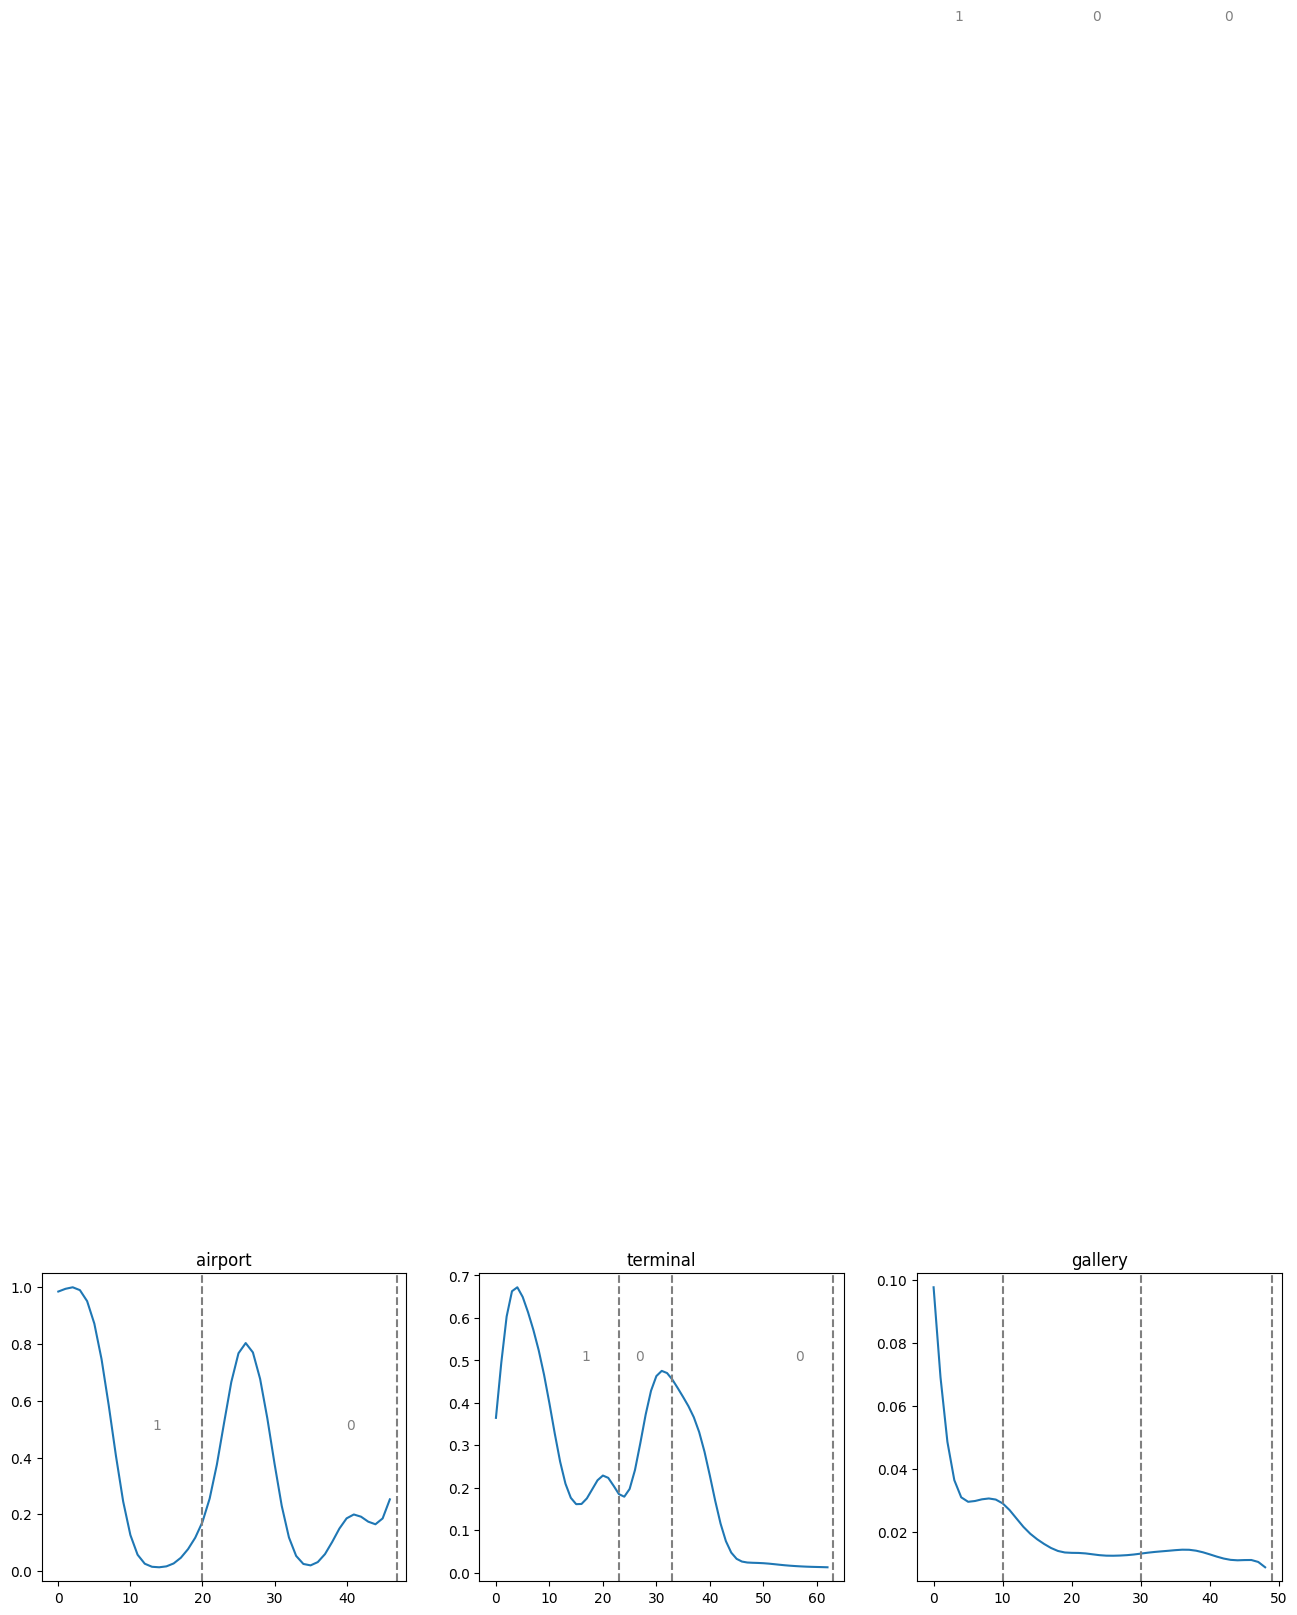

In [27]:
# plot the contours
import matplotlib.pyplot as plt
# create a figure with one row and the number of columns equal to the number of contours_combined
fig, axs = plt.subplots(nrows=1, ncols=len(contours_combined), figsize=(16,4))

# iterate over the contours_combined and plot each on a different subplot
k = 0
for i, cont in enumerate(contours_combined):
    axs[i].plot(cont)

    prev = 0
    for vertical_line_position in contlens_cumsum[i]:
        axs[i].axvline(x=vertical_line_position, color='gray', linestyle='--')
        # display a number at the top of each vertical line
        axs[i].text(vertical_line_position - 7, 0.5, str(all_labels[k]), rotation=0, color='gray')
        k += 1
        prev = vertical_line_position

    axs[i].set_title(all_words[i])

plt.show()

In [28]:
# train data
all_chunks = []
all_labels = []
for i, file in enumerate(ger_train_files):
    chunks, labels, success = feature_contour(file, False)

    if success:
        all_chunks.extend(chunks)
        all_labels.extend(labels)   

    clear_output(wait=True)
    print("Processed: {}/{}".format(i+1, len(ger_train_files)), end="\r")
    print("Progress: {:.2f}%".format((i+1)/len(ger_train_files)*100), end="\r")

KeyboardInterrupt: 

In [ ]:
# train data
all_chunks = []
all_labels = []
for i, file in enumerate(ita_train_files):
    chunks, labels = feature_contour(file, False)
    if chunks == None:
        continue
    all_chunks.extend(chunks)
    all_labels.extend(labels)

    print("Progress: {:.2f}%".format((i+1)/len(ita_train_files)*100), end="\r")
    print("Processed: {}/{}".format(i+1, len(ita_train_files)), end="\r")
    clear_output(wait=True)

In [ ]:
# save train data as pickle
df = pd.DataFrame({'contour': all_chunks, 'labels': all_labels})
df.to_pickle('../saved/ger_train_onlypoly.pkl')

In [ ]:
# test data
test_chunks = []
test_labels = []

for i, file in enumerate(ger_test_files):
    chunks, labels, success = feature_contour(file, True)
    
    if success:
        test_chunks.extend(chunks)
        test_labels.extend(labels)

    clear_output(wait=True)
    print("Progress: {:.2f}%".format((i+1)/len(ger_test_files)*100), end="\r")
    print("Processed: {}/{}".format(i+1, len(ger_test_files)), end="\r")

In [ ]:
# save train data as pickle
df = pd.DataFrame({'contour': test_chunks, 'labels': test_labels})
df.to_pickle('../saved/ger_test_onlypoly.pkl')

In [ ]:
# test data
test_chunks = []
test_labels = []

for i, file in enumerate(ger_test_files):
    chunks, labels, success = feature_contour(file, True)
    if not success:
        continue
    test_chunks.extend(chunks)
    test_labels.extend(labels)

    print("Progress: {:.2f}%".format((i+1)/len(ita_test_files)*100), end="\r")
    print("Processed: {}/{}".format(i+1, len(ita_test_files)), end="\r")
    clear_output(wait=True)

In [ ]:
# save train data as pickle
df = pd.DataFrame({'contour': test_chunks, 'labels': test_labels})
df.to_pickle('ita_test.pkl')

In [ ]:
print(len(test_chunks))

12524


In [ ]:
# make a dataframe
df = pd.DataFrame({'contour': all_chunks, 'labels': all_labels})
df.head()

,chunks,labels
0,"[0.01659550862520646, 0.01659550862520646, 0.0...",1
1,"[0.20705475938828283, 0.20705475938828283, 0.1...",1
2,"[0.0853309212266154, 0.0853309212266154, 0.085...",1
3,"[0.017483717247693344, 0.017483717247693344, 0...",1
4,"[0.015928296040650866, 0.015928296040650866, 0...",1


In [ ]:
# save the dataframe
df.to_pickle('data.pkl')

In [ ]:
# load the dataframe
df2 = pd.read_pickle('data.pkl')

In [ ]:
df = pd.DataFrame({'contour': test_chunks})
df.head()

,chunks
0,"[0.013564021110304844, 0.013564021110304844, 0..."
1,"[0.4396198379683321, 0.4396198379683321, 0.280..."
2,"[0.08664379438552769, 0.08664379438552769, 0.1..."
3,"[0.05106373959591337, 0.05106373959591337, 0.0..."
4,"[0.011421340988226685, 0.011421340988226685, 0..."


In [ ]:
df.to_pickle('test.pkl')